## Import libraries

In [1]:
import copy

from vtkmodules.util.numpy_support import vtk_to_numpy

import os, tempfile, nibabel as nib

import abagen
from abagen.images import check_atlas, relabel_gifti
from abagen import get_expression_data  # abagen>=0.1 uses this module name; if not, try: from abagen import get_expression_data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from brainspace.utils.parcellation import reduce_by_labels
from brainspace.mesh.mesh_io import write_surface  # BrainSpace I/O
from matplotlib.cm import get_cmap

from brainstat.context.genetics import surface_genetic_expression
from brainstat.datasets import fetch_parcellation
from brainstat.datasets import fetch_template_surface

from nibabel.freesurfer.io import read_annot
from netneurotools import datasets as nnt_datasets


## Get parcellation and expression

In [2]:
TEMPLATE = "fsaverage5"   # or "fsaverage" / "fsaverage6"

def find_aparc_annot_from_freesurfer(template="fsaverage5"):
    """
    Returns (lh_annot_path, rh_annot_path) by searching a FreeSurfer install.
    """
    fs_home = os.environ.get("FREESURFER_HOME", "")
    if not fs_home:
        raise FileNotFoundError(
            "FREESURFER_HOME is not set. Install FreeSurfer and export FREESURFER_HOME, "
            "or point directly to your aparc.annot files."
        )
    subj = {"fsaverage":"fsaverage", "fsaverage5":"fsaverage5", "fsaverage6":"fsaverage6"}[template]
    base = os.path.join(fs_home, "subjects", subj, "label")
    lh = os.path.join(base, "lh.aparc.annot")
    rh = os.path.join(base, "rh.aparc.annot")
    if not (os.path.isfile(lh) and os.path.isfile(rh)):
        raise FileNotFoundError(
            f"Could not find aparc.annot under {base}\n"
            f"Expected: {lh}\n          {rh}"
        )
    return lh, rh

## Get geometry from BrainStat and save gifti files for each hemisphere

In [3]:
# 1) Get geometry from BrainStat (we just need it as GIFTIs for abagen)
lh_bs, rh_bs = fetch_template_surface(TEMPLATE, join=False)  # or layer="white"
tmpdir = tempfile.mkdtemp(prefix="dk_geom_")
lh_surf_path = os.path.join(tmpdir, "lh.surf.gii")
rh_surf_path = os.path.join(tmpdir, "rh.surf.gii")
write_surface(lh_bs, lh_surf_path)
write_surface(rh_bs, rh_surf_path)

## Extract labels according to the DK atlas

In [4]:
# 2) Find and read aparc.annot → per-vertex labels
lh_annot, rh_annot = find_aparc_annot_from_freesurfer(TEMPLATE)
lh_labels = read_annot(lh_annot)[0].astype(np.int32)
rh_labels = read_annot(rh_annot)[0].astype(np.int32)

In [6]:
# 3) Offset RH by +34 (34 cortical parcels per hemisphere)
rh_labels = np.where(rh_labels != 0, rh_labels + 34, 0).astype(np.int32)
labels_vec_dk = np.hstack([lh_labels, rh_labels])

## Build atlas and compute expression file

In [7]:
# 4) Build atlas + compute expression on DK parcels (no relabel_gifti needed)
atlas_dk = check_atlas(labels_vec_dk, geometry=(lh_surf_path, rh_surf_path), space="fsaverage")
expr_dk = get_expression_data(atlas_dk, probe_selection="max_intensity", donor_probes="aggregate")

/home/hanwang/.pyenv/versions/abagen-pyenv/lib/python3.11/site-packages/abagen/probes_.py:181: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retained = info.groupby('gene_symbol').apply(applyfunc).dropna().squeeze()
/home/hanwang/.pyenv/versions/abagen-pyenv/lib/python3.11/site-packages/abagen/samples_.py:405: FutureWarning: The provided callable <function mean at 0x76975438a0c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  microarray.groupby('label').aggregate(metric),
/home/hanwang/.pyenv/versions/abagen-pyenv/lib/python3.11/site-packages/abagen/samples_.py:404: FutureW

## Plot DK-genetic expression matrix.

/tmp/ipykernel_3405741/519989883.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = copy.copy(get_cmap())


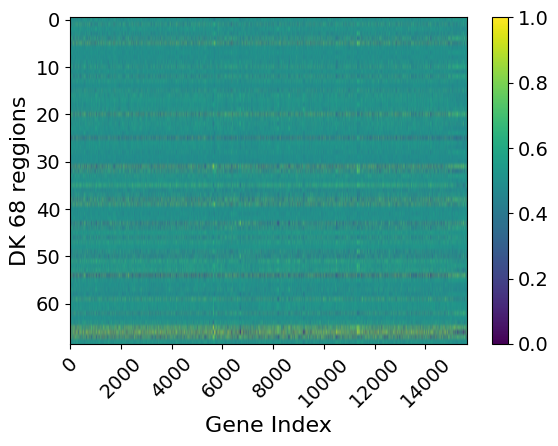

In [ ]:
# Plot DK-genetic expression matrix.
colormap = copy.copy(get_cmap())
colormap.set_bad(color="black")
plt.imshow(expr_dk, aspect="auto", cmap=colormap)
plt.colorbar().ax.tick_params(labelsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Gene Index", fontdict={"fontsize": 16})
plt.ylabel("68 DK reggions", fontdict={"fontsize": 16})
plt.gcf().subplots_adjust(bottom=0.2)

## Plot Single-gene expression

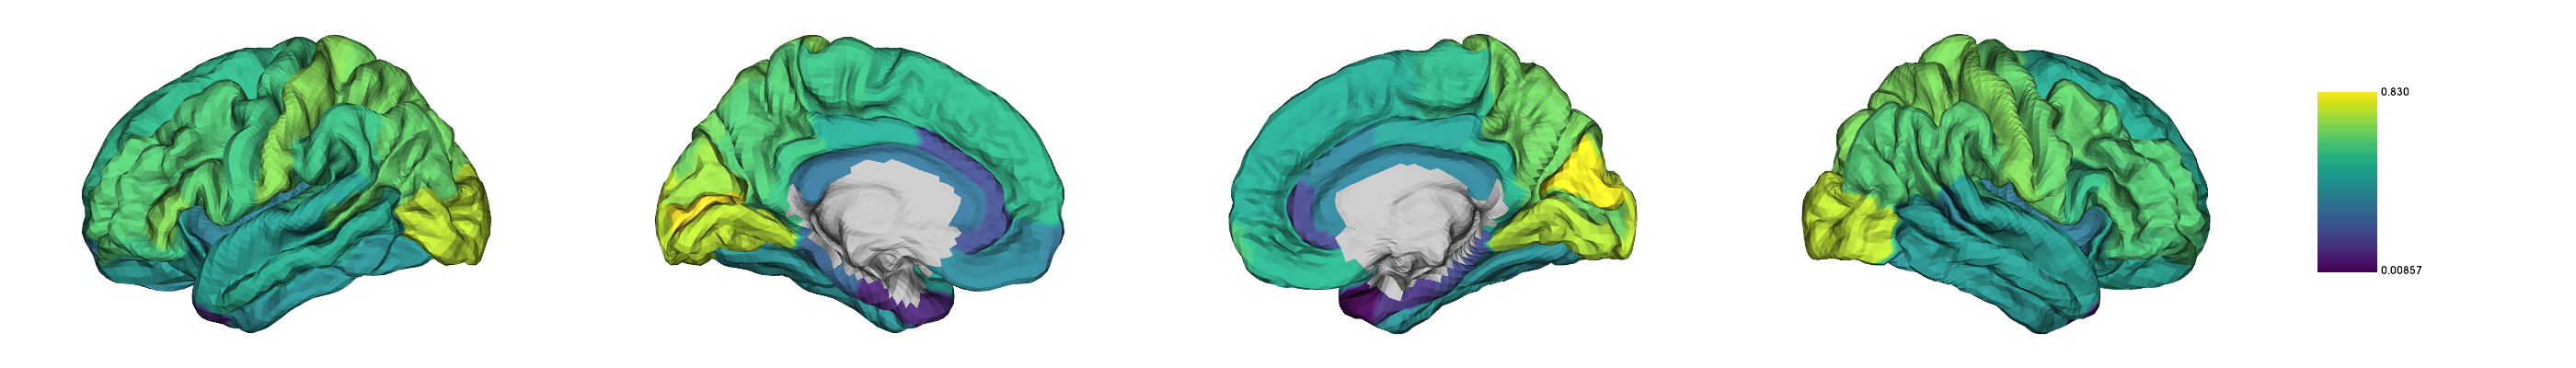

In [16]:
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

single_gene = "GRIN2A"

vertexwise_gene = map_to_labels(
    expr_dk[single_gene].to_numpy(),
    labels_vec_dk,
    mask=labels_vec_dk != 0,
    fill=np.nan,
    source_lab=expr_dk.index.astype(int).to_numpy(),  # <-- map by parcel IDs

)

plot_hemispheres(
    lh_bs, rh_bs,
    vertexwise_gene,
    color_bar=True,
    embed_nb=True,
    size=(2800, 400),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
)
